# Removing 'Leading' Features from dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [4]:
data = 'UpsampledDataset.csv'
upsampled = pd.read_csv(data)

On a previous Laso run these features were found to be the most impactful to dataset variance
Total principal repaid by the borrower up to this point. This excludes interest payments and reflects how much of the loan’s original amount has been returned.
Funds recovered after a loan has defaulted, often via collections or charged-off asset reclamation. A nonzero value here indicates a default occurred, and some money was clawed back.
Amount paid in the last payment cycle—includes both principal and interest. It’s useful to detect repayment patterns, stalling behavior, or payment shocks.
The upper bound of the borrower’s last reported FICO score range. LendingClub records FICO scores in ranges, and this represents the “optimistic” end. A falling range could signal distress.

These variables are cheating, the model is given too much information that hints at a default near the time of the actual default. 
So I compiled a list of 'good' features and will only keep those that are from the clean upsampled dataset and are good features.

In [32]:
good_features = [
    'loan_amnt',
    'funded_amnt',
    'funded_amnt_inv',
    'term',
    'int_rate',
    'installment',
    'emp_length',
    'home_ownership',
    'annual_inc',
    'dti',
    'delinq_2yrs',
    'fico_range_low',
    'fico_range_high',
    'inq_last_6mths',
    'open_acc',
    'pub_rec',
    'revol_bal',
    'revol_util',
    'total_acc',
    'collections_12_mths_ex_med',
    'policy_code',
    'acc_now_delinq',
    'tot_coll_amt',
    'tot_cur_bal',
    'total_rev_hi_lim',
    'acc_open_past_24mths',
    'avg_cur_bal',
    'bc_open_to_buy',
    'bc_util',
    'chargeoff_within_12_mths',
    'delinq_amnt',
    'mo_sin_old_il_acct',
    'mo_sin_old_rev_tl_op',
    'mo_sin_rcnt_rev_tl_op',
    'mo_sin_rcnt_tl',
    'mort_acc',
    'mths_since_recent_bc',
    'mths_since_recent_inq',
    'num_accts_ever_120_pd',
    'num_actv_bc_tl',
    'num_actv_rev_tl',
    'num_bc_sats',
    'num_bc_tl',
    'num_il_tl',
    'num_op_rev_tl',
    'num_rev_accts',
    'num_rev_tl_bal_gt_0',
    'num_sats',
    'num_tl_120dpd_2m',
    'num_tl_30dpd',
    'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m',
    'pct_tl_nvr_dlq',
    'percent_bc_gt_75',
    'pub_rec_bankruptcies',
    'tax_liens',
    'tot_hi_cred_lim',
    'total_bal_ex_mort',
    'total_bc_limit',
    'total_il_high_credit_limit',
    'hardship_flag',
    'disbursement_method',
    'debt_settlement_flag',
    'grade_num',
    'is_default'  # Include the target
]


In [59]:
# Filter the DataFrame to keep only the good features
df_filtered = upsampled[[col for col in good_features if col in upsampled.columns]]

# Optional: check result
print(f"Filtered dataset shape: {df_filtered.shape}")
print("Columns retained:", df_filtered.columns.tolist())

# Save to new CSV if needed
df_filtered.to_csv("filtered_loan_data.csv", index=False)


Filtered dataset shape: (1581250, 65)
Columns retained: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'emp_length', 'home_ownership', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_b

77 down to 65, 12 features were removed. 

# Load in only Tier 1 features dataset

In [34]:
df_filtered = pd.read_csv("tier_1_features_only.csv")

77 down to 18... Then int rate was the only important var so I got rid of it

# GridSearchCV with Pipeline for Lasso Regression


In [38]:

X = df_filtered.drop('is_default', axis=1)
y = df_filtered['is_default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

In [42]:
search = GridSearchCV(pipeline,
                      {'model__alpha': np.arange(0.1,10,0.1)},
                      cv = 5,verbose=3
                      )

In [44]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END .................model__alpha=0.1;, score=-0.000 total time=   0.5s
[CV 2/5] END .................model__alpha=0.1;, score=-0.000 total time=   0.5s
[CV 3/5] END .................model__alpha=0.1;, score=-0.000 total time=   0.6s
[CV 4/5] END .................model__alpha=0.1;, score=-0.000 total time=   0.4s
[CV 5/5] END .................model__alpha=0.1;, score=-0.000 total time=   0.5s
[CV 1/5] END .................model__alpha=0.2;, score=-0.000 total time=   0.4s
[CV 2/5] END .................model__alpha=0.2;, score=-0.000 total time=   0.4s
[CV 3/5] END .................model__alpha=0.2;, score=-0.000 total time=   0.5s
[CV 4/5] END .................model__alpha=0.2;, score=-0.000 total time=   0.4s
[CV 5/5] END .................model__alpha=0.2;, score=-0.000 total time=   0.5s
[CV 1/5] END .model__alpha=0.30000000000000004;, score=-0.000 total time=   0.4s
[CV 2/5] END .model__alpha=0.30000000000000004;

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             verbose=3)

In [46]:
search.best_params_

{'model__alpha': 0.1}

In [48]:
coefficients = search.best_estimator_.named_steps['model'].coef_

In [50]:
importance = np.abs(coefficients)
print(importance)
print(len(importance))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
16


In [52]:
features = df_filtered.columns
if len(importance) < len(features):
    # If there are more features than coefficients, trim the features array
    features = features[:len(importance)]
elif len(importance) > len(features):
    # If there are more coefficients than features, pad the features array
    features = np.pad(features, (0, len(importance) - len(features)), mode='constant', constant_values='')

# Select features with non-zero coefficients
features_lasso = np.array(features)[importance != 0]
print(len(features))
# Print the selected features
print(features_lasso)

16
[]


In [54]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
alpha = 0.1  # Adjust this value for the strength of the regularization
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=0.1)

In [58]:
y_pred = lasso_model.predict(X_test_scaled)

In [60]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
lasso_coefficients = lasso_model.coef_

# Print the results
print(f'Mean Squared Error: {mse}')
print(f'Lasso Coefficients: {lasso_coefficients}')

Mean Squared Error: 0.15884138986745835
Lasso Coefficients: [ 0.  0.  0.  0. -0.  0. -0. -0. -0. -0.  0.  0.  0. -0.  0. -0.]


# Random Forest Classifier with Lasso Feature Selection

In [63]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt

In [67]:
X_best = df_filtered[features_lasso]

In [69]:
X_best

""
0
1
2
3
4
...
986035
986036
986037
986038


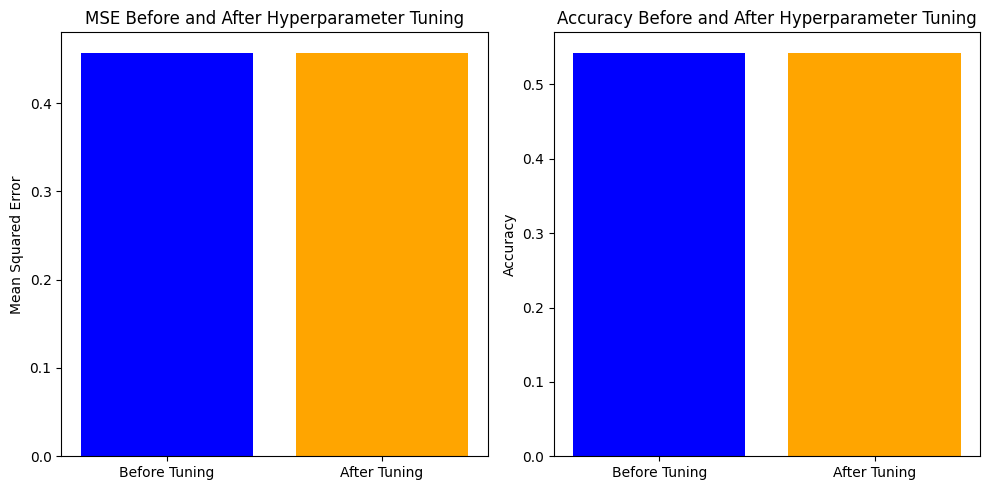

In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt

# Assuming 'X' and 'y' are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
target_variable = 'is_default'

# Exclude the target variable from the features
lasso_features = [feature for feature in features_lasso if feature != target_variable]
# Assuming 'lasso_features' contains the features selected by Lasso
X_train_lasso = X_train[lasso_features]
X_test_lasso = X_test[lasso_features]

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the Random Forest Classifier with training data
rf_classifier.fit(X_train_lasso, y_train)

# Choose RandomizedSearchCV for hyperparameter tuning
rf_random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
rf_random_search.fit(X_train_lasso, y_train)

# Get the best model
rf_best_classifier = rf_random_search.best_estimator_

# Predict using the trained model before hyperparameter tuning
rf_pred_before = rf_classifier.predict(X_test_lasso)
mse_before = mean_squared_error(y_test, rf_pred_before)
accuracy_before = accuracy_score(y_test, rf_pred_before)

# Predict using the best model after hyperparameter tuning
rf_pred_after = rf_best_classifier.predict(X_test_lasso)
mse_after = mean_squared_error(y_test, rf_pred_after)
accuracy_after = accuracy_score(y_test, rf_pred_after)

# Visualize MSE and accuracy before and after hyperparameter tuning
plt.figure(figsize=(10, 5))

# Plot MSE
plt.subplot(1, 2, 1)
plt.bar(['Before Tuning', 'After Tuning'], [mse_before, mse_after], color=['blue', 'orange'])
plt.title('MSE Before and After Hyperparameter Tuning')
plt.ylabel('Mean Squared Error')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.bar(['Before Tuning', 'After Tuning'], [accuracy_before, accuracy_after], color=['blue', 'orange'])
plt.title('Accuracy Before and After Hyperparameter Tuning')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [100]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

In [ ]:
from sklearn.svm import SVC
# Create SVM classifier
svm_classifier = SVC(random_state=42)

# Choose GridSearchCV for hyperparameter tuning
svm_grid_search = GridSearchCV(svm_classifier, param_grid=param_grid, cv=7, scoring='accuracy')
svm_grid_search.fit(X_train_lasso, y_train)

In [ ]:
# Get the best model
svm_best_classifier = svm_grid_search.best_estimator_

# Fit the best SVM model with the training data
svm_best_classifier.fit(X_train_lasso, y_train)

In [25]:
# Predict using the trained SVM model before hyperparameter tuning
svm_pred_before = svm_best_classifier.predict(X_test_lasso)
mse_before_svm = mean_squared_error(y_test, svm_pred_before)
accuracy_before_svm = accuracy_score(y_test, svm_pred_before)

# Predict using the best SVM model after hyperparameter tuning
svm_pred_after = svm_best_classifier.predict(X_test_lasso)
mse_after_svm = mean_squared_error(y_test, svm_pred_after)
accuracy_after_svm = accuracy_score(y_test, svm_pred_after)

Text(0, 0.5, 'Mean Squared Error')

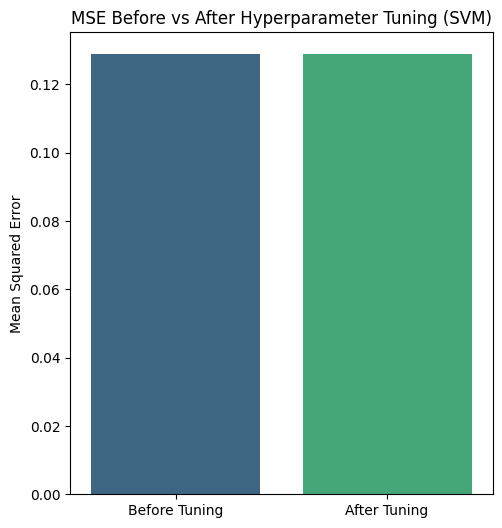

In [26]:
# Visualize MSE and accuracy before and after hyperparameter tuning for SVM
plt.figure(figsize=(12, 6))

# MSE Before vs After
plt.subplot(1, 2, 1)
sns.barplot(x=['Before Tuning', 'After Tuning'], y=[mse_before_svm, mse_after_svm], palette='viridis')
plt.title('MSE Before vs After Hyperparameter Tuning (SVM)')
plt.ylabel('Mean Squared Error')

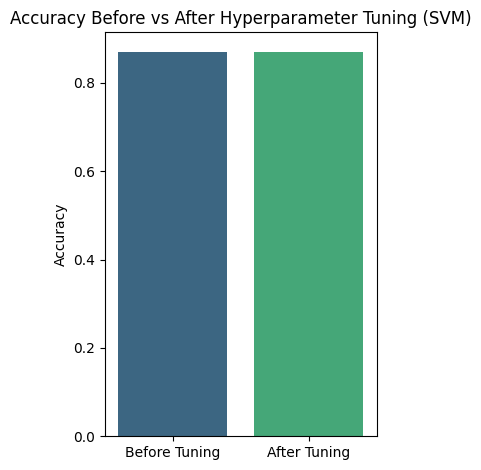

In [27]:
# Accuracy Before vs After
plt.subplot(1, 2, 2)
sns.barplot(x=['Before Tuning', 'After Tuning'], y=[accuracy_before_svm, accuracy_after_svm], palette='viridis')
plt.title('Accuracy Before vs After Hyperparameter Tuning (SVM)')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [28]:
print(f"Accuracy Before Tuning (SVM): {accuracy_before_svm:.4f}")
print(f"MSE Before Tuning (SVM): {mse_before_svm:.4f}\n")

print(f"Accuracy After Tuning (SVM): {accuracy_after_svm:.4f}")
print(f"MSE After Tuning (SVM): {mse_after_svm:.4f}")

Accuracy Before Tuning (SVM): 0.8712
MSE Before Tuning (SVM): 0.1288

Accuracy After Tuning (SVM): 0.8712
MSE After Tuning (SVM): 0.1288


It seems that the hyperparameter tuning didn't significantly impact the performance of the SVM model on our dataset, as the accuracy and mean squared error (MSE) values are very close before and after tuning.